# Métaheuristique pour le voyageur de commerce

On souhaite résoudre le problème du voyageur de commerce à l'aide d'une métaheuristique.

Le problème du voyageur de commerce euclidien consiste, étant donné un ensemble de `n` points en 2D, à déterminer un tour de plus petite distance reliant ces points.

## Questions préliminaires

Avant de chercher une bonne solution pour le problème, on doit se poser les questions suivantes : 
- Qu'est-ce qu'une solution du TSP ? Algorithmiquement ?
- Comment la représenter algorithmiquement ?
- Quel est le nombre de solutions pour le problème si j'ai 5 villes ? `n` villes ?

## Import et initialisation du code

Les 3 cellules suivantes sont à exécuter avant de commencer.

In [1]:
import random as r
import math as m
from time import time
# Pour l'affichage des points et des tournées
import matplotlib.pyplot as plt

# Pour pouvoir utiliser les tuples nommés
from collections import namedtuple

In [2]:
%matplotlib inline

In [3]:
# pour redimensionner les figures par défaut
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## Génération des points et création de l'instance du problème de voyageur de commerce euclidien

On souhaite définir une instance aléatoire.
Pour cela, on crée deux tableaux `x` et `y` contenant les abscisses et les ordonnées des points. Les valeurs sont des nombres entiers entre 0 et 100. On calcule ensuite les distances entre toute paire de points que l'on stocke dans un tableau de tableaux.

Pour simplifier l'accès aux données, on utilise les [tuples nommés](https://dbader.org/blog/writing-clean-python-with-namedtuples).


In [4]:
# Namedtuple pour stocker une instance
Coordonnes = namedtuple("Coordonnes", ["x", "y"])
Instance = namedtuple("Instance", ["coords", "d"])

def create_random_instance(n):
    """crée une instance avec n points
    """
    # Coordonnées aléatoires des points (abscisses et ordonnées)
    x = [ r.randint(0, 100)  for _ in range(n) ]
    y = [ r.randint(0, 100)  for _ in range(n) ]

    # Calcul des distances
    d = [ [m.sqrt((x[i]-x[j])**2 + (y[i] - y[j])**2) for j in range(n) ] for i in range(n)]

    # Création de l'instance avec les namedtuples
    coords = Coordonnes(x, y)
    ins = Instance(coords, d)

    return ins



def affichage_instance(ins, labels = True):
    n = len(ins.coords.x)
    plt.scatter(ins.coords.x, ins.coords.y)
    if labels:
        for i in range(n):
            plt.annotate(i, (ins.coords.x[i] + 1, ins.coords.y[i] + 1))



## Solution du voyageur de commerce

On peut représenter une solution du voyageur de commerce à l'aide d'un tableau contenant la séquence des indices des points. Si l'on a `n` points, on a donc un tableau contenant les entiers de `0` à `n-1` inclus.

Par exemple, si l'on a 5 points, alors une solution peut être `[0, 3, 1, 2, 4]`. Cela signifie que le tour visite le point numéro 0, puis les points du numéro 3, 2 puis 4 avant de revenir au point numéro 0.

Le tour passant par les points 0, 1, ..., `n-1` peut donc être défini par :

In [5]:
def get_random_tour(ins):
    """
    Retourne un tour aléatoire
    """
    t = list(range(len(ins.coords.x)))
    r.shuffle(t)
    return t



On peut maintenant définir une fonction d'affichage pour un tour sur l'instance de la manière suivante :

In [6]:
def affichage_tour(ins, tour, nom_legende="", labels = True):
    affichage_instance(ins, labels)
    tour_avec_retour = tour + [tour[0]]
    x = [ins.coords.x[p] for p in tour_avec_retour]
    y = [ins.coords.y[p] for p in tour_avec_retour]
    if nom_legende != "":
        plt.plot(x, y, "o-", label=nom_legende)
        plt.legend()
    else:
        plt.plot(x, y, "o-")


## Coût d'un tour

Il faut maintenant déterminer le coût d'une tournée. 
Définir la fonction `cout_tour` prenant en paramètre une instance et un tour et retournant le coût de ce tour, c'est-à-dire la distance parcourue pour effectuer ce tour.

In [7]:
def cout_tour(ins, tour):
    total = 0
    for i in range(len(tour)-1):
        total += ins.d[tour[i]][tour[i+1]]
    return total + ins.d[tour[0]][tour[-1]]


## Heuristiques pour la construction d'une première solution

Il faut maintenant définir une ou plusieurs heuristiques et les implémenter. 

In [13]:
def plus_proche_voisin(ins, first):
    """
    Retourne un tour construit avec l'heuristique du plus proche voisin, à partir du sommet numéro first
    """
    sommets_a_ajouter = list(range(len(ins.coords.x)))
    
    # On supprime le sommet first de la liste des sommets
    sommets_a_ajouter[first] = sommets_a_ajouter[-1]
    sommets_a_ajouter.pop()
    
    tour = [first]
    
    # Tant qu'il reste des sommets à insérer
    while len(sommets_a_ajouter) > 0:
        
        # On cherche le sommet le plus proche du dernier sommet du tour
        i_min = 0
        d_min = ins.d[tour[-1]][sommets_a_ajouter[0]]
        for i in range(1, len(sommets_a_ajouter)):
            if ins.d[tour[-1]][sommets_a_ajouter[i]] < d_min:
                d_min = ins.d[tour[-1]][sommets_a_ajouter[i]]
                i_min = i
            
        # On ajoute ce sommet dans le tour et on le supprime de la liste des sommets à insérer
        tour.append(sommets_a_ajouter[i_min])
        sommets_a_ajouter[i_min] = sommets_a_ajouter[-1]
        sommets_a_ajouter.pop()
    return tour

## Métaheuristique pour le TSP

Définir une ou plusieurs métaheuristiques pour le TSP.
Pour cela, définir un ou plusieurs voisinages. Définir ensuite une ou plusieurs métaheuristiques (descente, descente avec départ multiples, recuit simulé, recherche tabou, etc). Comparer les différentes méthodes entre elles (qualité des solutions, temps de résolution, nombre d'itérations, etc).


In [15]:
def descente(ins, initial_sol, find_best_neighbor):
    """
    Effectue une métaheuristique de type descente.
    Paramètres : 
    - ins: instance du problème
    - initial_sol: solution initial
    - find_best_neighbor: fonction cherchant la meilleure solution voisine et 
                          mettant à jour la solution passée en paramètre.
                          -> find_best_neighbor(ins, s) retourne True si s a été modifiée 
    """
    s = initial_sol.copy()
    hasFoundBetterSol = True
    while hasFoundBetterSol:
        hasFoundBetterSol = find_best_neighbor(ins, s)
    return s


def find_best_neighbor_permutation(ins, current_sol):
    """
    Cherche la meilleure solution voisine de current_sol obtenue en permutant deux villes de la tournée.
    Met à jour current_sol si la meilleure solution voisine est meilleure que current_sol
    """
    best = cout_tour(ins, current_sol)
    best_ind = (0, 0)
    for i in range(len(current_sol)):
        for j in range(i+1, len(current_sol)):
            current_sol[i], current_sol[j] = current_sol[j], current_sol[i]
            tmp = cout_tour(ins, current_sol)
            if tmp < best:
                best = tmp
                best_ind = (i, j)
            current_sol[i], current_sol[j] = current_sol[j], current_sol[i]
    if best_ind != (0, 0):
        i, j = best_ind
        current_sol[i], current_sol[j] = current_sol[j], current_sol[i]
        return True
    else:
        return False


In [14]:
def find_best_2opt(ins, current_sol):
    """
    Cherche la meilleure solution voisine de current_sol obtenue en supprimant deux arêtes non adjacente
    et en reconnectant le tour (Voisinage 2-OPT).
    Met à jour current_sol si la meilleure solution voisine est meilleure que current_sol
    """
    n = len(current_sol)
    best_diff = 0
    best_ind = (0, 0)
    for i in range(len(current_sol) - 1):
        for j in range(i+2, len(current_sol)):
            
            diff = ins.d[current_sol[i]][current_sol[j]] + ins.d[current_sol[i+1]][current_sol[(j+1)%n]] 
            diff -= ins.d[current_sol[i]][current_sol[i+1]] + ins.d[current_sol[j]][current_sol[(j+1)%n]]
            if diff < best_diff:
                best_diff = diff
                best_ind = (i, j)


    if best_diff < 0:
        i, j = best_ind
        
        
        current_sol[i+1:j+1] = reversed(current_sol[i+1:j+1])
        return True
    else:
        return False


## Résultats expérimentaux

cout tour initial 10933.01708579801
Algorithme du plus proche voisin (à partir de 0). Sol de coût 1452.5948079095194 calculé en 0.007799625396728516 sec
cout descente permutation 2313.880703278393 calculé en 147.06488847732544 sec
cout descente 2-opt 1286.2258588669145 calculé en 2.3527278900146484 sec


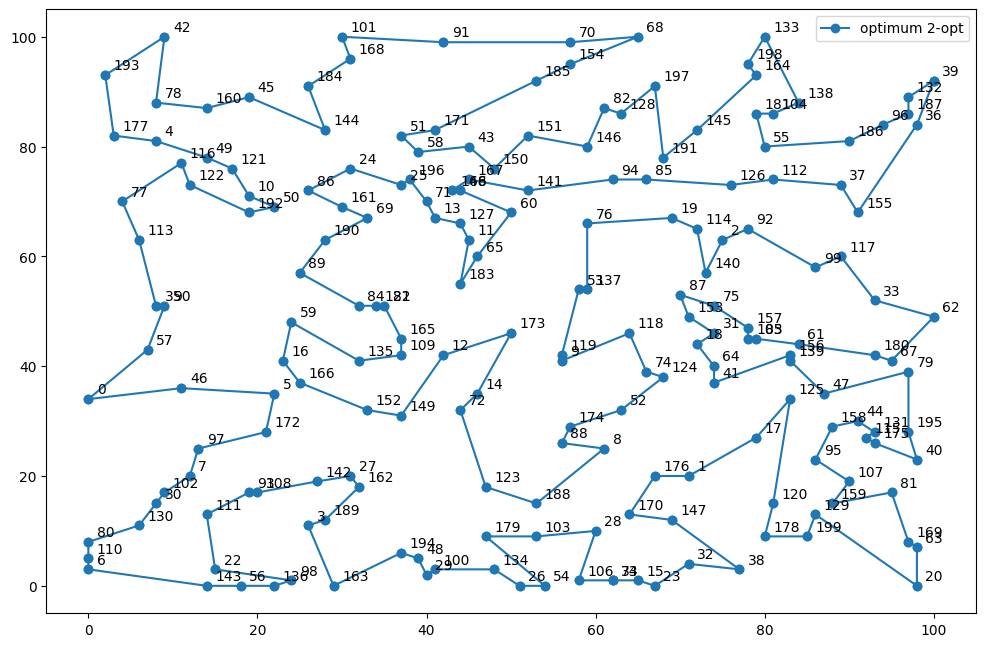

In [16]:
ins = create_random_instance(200)
tour_initial = get_random_tour(ins)
print("cout tour initial", cout_tour(ins, tour_initial))


tic = time()
tour_ppv = plus_proche_voisin(ins, 0)
tac = time()
print("Algorithme du plus proche voisin (à partir de 0). Sol de coût", 
      cout_tour(ins, tour_ppv), "calculé en", (tac-tic), "sec")

tic = time()
tour_permutation = descente(ins, tour_initial, find_best_neighbor_permutation)
tac = time()
print("cout descente permutation", cout_tour(ins, tour_permutation), "calculé en", (tac-tic), "sec")

tic = time()
tour_2opt = descente(ins, tour_initial, find_best_2opt)
tac = time()
print("cout descente 2-opt", cout_tour(ins, tour_2opt), "calculé en", (tac-tic), "sec")
affichage_tour(ins, tour_2opt, "optimum 2-opt") 